In [1]:
# import the needed packages
import pandas as pd
import stlearn as st
import scanpy as sc
import matplotlib.pyplot as plt
import os
import numpy as np
import anndata as ad
import seaborn as sns; sns.set(color_codes=True)
import scipy.stats as stats
import math

import cupy as cp
import rapids_singlecell as rsc

import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

# clr normalization method courtesy of maximz
# https://github.com/scverse/scanpy/issues/1208
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [2]:
# read the whole TMA slide but concatenated from individual cores
# replace expmat and meta with the paths to your expression matrix and metadata respectively
expmat = pd.read_csv('/mnt/scratch1/Luke/CosMXTest/ProteinPRFlatFiles/SAHA_Protein_Section4_CosMx_9224_StJude_13124_HC_22424/SAHA_Protein_Section4_CosMx_9224_StJude_13124_HC_22424_exprMat_file.csv')
meta = pd.read_csv('/mnt/scratch1/Luke/CosMXTest/ProteinPRFlatFiles/SAHA_Protein_Section4_CosMx_9224_StJude_13124_HC_22424/SAHA_Protein_Section4_CosMx_9224_StJude_13124_HC_22424_metadata_file.csv')

# create a stlearn adata using the flatfiles
count_matrix = expmat.drop(['fov', 'cell_ID'], axis=1)
spatial = meta[['CenterX_global_px', 'CenterY_global_px']]
spatial = spatial.rename(columns={'CenterX_global_px': 'imagecol', 'CenterY_global_px': 'imagerow'})

adata = st.create_stlearn(count=count_matrix,spatial=spatial,
                                library_id="Sample_test", scale=1,background_color="white")
adata.obs['fov'] = meta['fov'].values
print(adata)
adata.write_h5ad('adataPR.h5ad')

/home/lzhang36/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 66785 × 69
    obs: 'imagecol', 'imagerow', 'fov'
    uns: 'spatial'
    obsm: 'spatial'


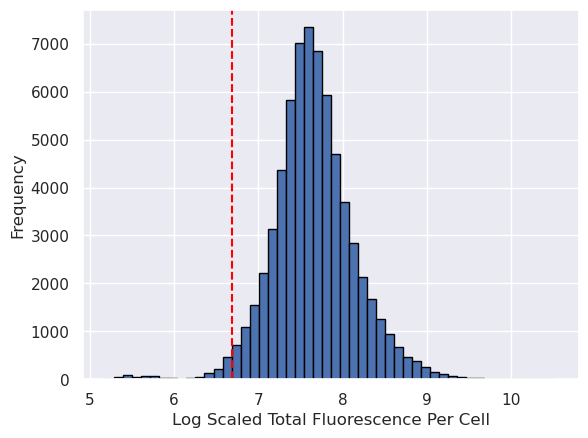

View of AnnData object with n_obs × n_vars = 65542 × 64
    obs: 'imagecol', 'imagerow', 'fov'
    uns: 'spatial'
    obsm: 'spatial'


View of AnnData object with n_obs × n_vars = 65542 × 64
    obs: 'imagecol', 'imagerow', 'fov'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
# remove the control genes
genes_to_remove = ['Channel-CD45', 'Channel-DNA', 'Channel-G', 'Channel-Membrane', 'Channel-PanCK']
adata_clr = ad.read_h5ad('adataPR.h5ad')
adata_clr = adata_clr[:,~adata_clr.var_names.isin(genes_to_remove)]

# do some basic filtering based on fluorescence
matrix = adata_clr.X 
cutoff_std = np.mean(np.log(np.sum(matrix, axis=1)))-2*(np.std(np.log(np.sum(matrix, axis=1))))
plt.hist(np.log(np.sum(matrix, axis=1)), bins=50, edgecolor='black')
plt.ylabel('Frequency')
plt.xlabel('Log Scaled Total Fluorescence Per Cell')
plt.axvline(x=cutoff_std, color='red', linestyle='--')
plt.show()

idx = np.where(np.log(np.sum(matrix, axis=1)) > cutoff_std)[0]
adata_clr = adata_clr[idx,:]
print(adata_clr)

# normalize the cells
clr_normalize_each_cell(adata_clr)

/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/rapids_singlecell/preprocessing/_pca.py:135: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


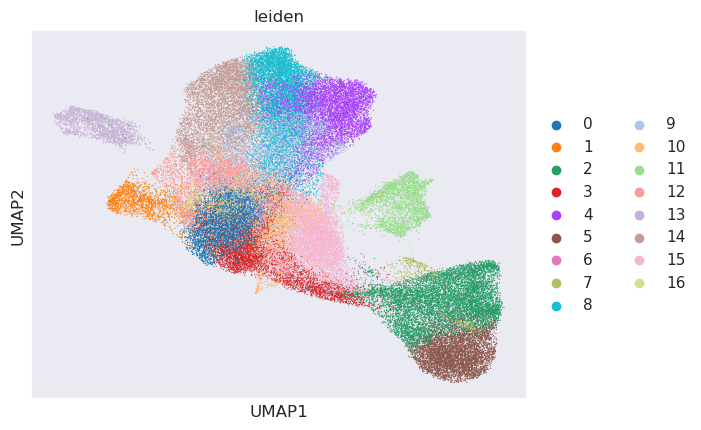

Scale step is finished in adata.X


/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


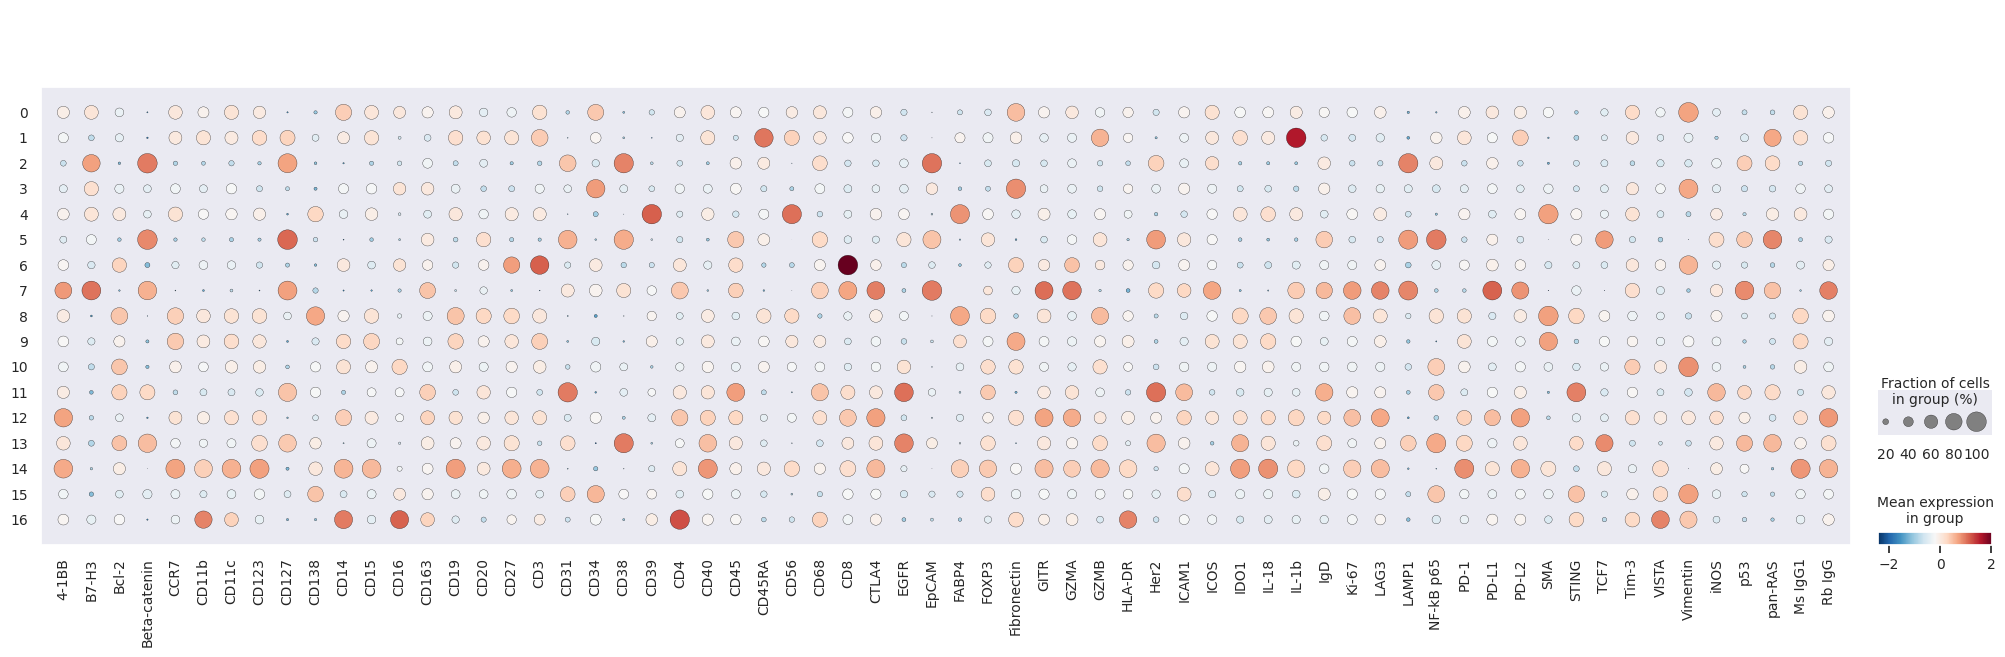

In [4]:
# perform leiden clustering 
rsc.pp.pca(adata_clr, n_comps=50)
rsc.pp.neighbors(adata_clr, n_neighbors=30, n_pcs=50, use_rep='X_pca')
rsc.tl.umap(adata_clr)
rsc.tl.leiden(adata_clr, resolution=1)
# map the leiden onto UMAP
sc.pl.umap(adata_clr, color=['leiden'], size=3)
# create the dotplot for manual cell annotations
st.pp.scale(adata_clr)
sc.pl.dotplot(adata_clr, adata_clr.var_names.to_list(), groupby='leiden', dendrogram=False, log=True, cmap='RdBu_r')

/mnt/scratch1/miniconda3/envs/rsc_conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


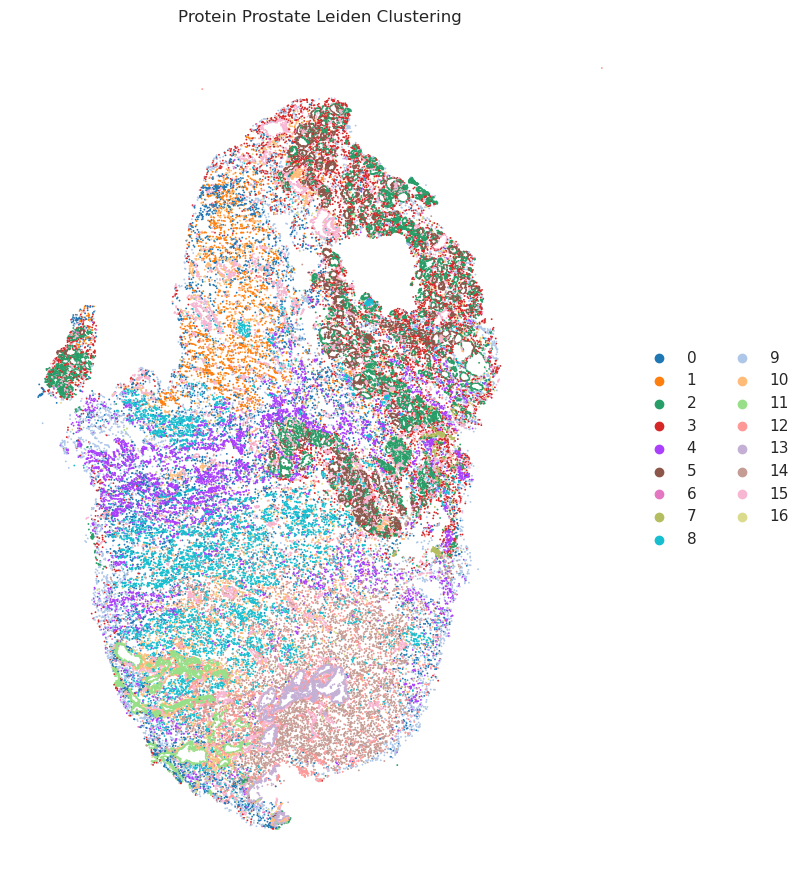

In [5]:
# plot the leiden clustering onto the tissue
fig, ax = plt.subplots(figsize=(8, 12))
sc.pl.embedding(adata_clr, basis='spatial', color='leiden', show=False, ax=ax, size=7)
# Set the axis labels and aspect ratio on the current Axes object
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_facecolor('white')
ax.set_title('Protein Prostate Leiden Clustering')
plt.show()